In [11]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import zscore
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [6]:
# import dataset (comes with colab!)
data = np.loadtxt(open("../Datasets/mnist_train_small.csv", "rb"), delimiter=",")

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [7]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, test_size=0.1
)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device)
)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device=device))

In [8]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 64)

            ### hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ### output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer (Note: SGD to slow down learning!)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [9]:
def function2trainTheModel(net, lossfun, optimizer, numepochs=60):

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # initialize weight change matrices
    weightChange = np.zeros((numepochs, 4))
    weightConds = np.zeros((numepochs, 4))

    # loop over epochs
    for epochi in range(numepochs):

        # store the weights for each layer
        preW = []
        for p in net.named_parameters():
            if "weight" in p[0]:
                preW.append(copy.deepcopy(p[1].data.cpu().numpy()))

        # loop over training data batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.cpu().item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
            batchAcc.append(accuracyPct.cpu())  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu())

        # finally, get the post-learning state of the weights
        for i, p in enumerate(net.named_parameters()):
            if "weight" in p[0]:
                # condition number
                weightConds[epochi, int(i / 2)] = np.linalg.cond(p[1].data.cpu())

                # Frobenius norm of the weight change from pre-learning
                weightChange[epochi, int(i / 2)] = np.linalg.norm(
                    preW[int(i / 2)] - p[1].data.cpu().numpy(), ord="fro"
                )

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net, weightChange, weightConds, preW

In [10]:
# create the network
net, lossfun, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net, weightChange, weightConds, preW = (
    function2trainTheModel(net, lossfun, optimizer)
)

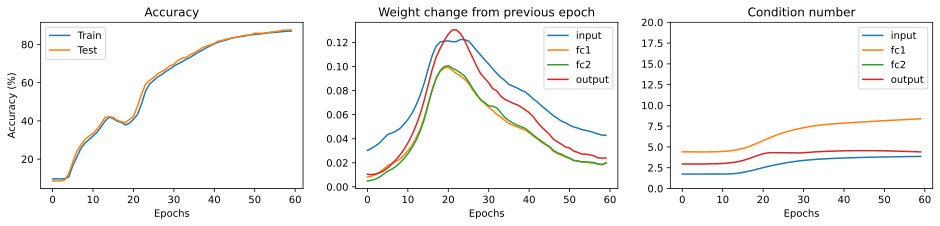

In [12]:
# Show the results!

# get a list of layer names
layername = []
for i, p in enumerate(net.named_parameters()):
    if "weight" in p[0]:
        layername.append(p[0][:-7])


# set up the plot
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].set_title("Accuracy")
ax[0].legend(["Train", "Test"])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel("Epochs")
ax[1].set_title("Weight change from previous epoch")
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel("Epochs")
ax[2].set_title("Condition number")
ax[2].legend(layername)
ax[2].set_ylim([0, 20])

plt.show()